In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import json

In [2]:

# Load the dataset
file_path = "../table/global-spatial-economics-datasets-public(datasets).csv"
df = pd.read_csv(file_path,encoding='windows-1252')

# Display the first few rows to understand the structure
df_subset = df[["ISIC Letter", "Dataset"]].copy()

isic_dict = json.load(open('/Users/cenv1069/Documents/data/notebooks/data/isic_dict.json',mode="r"))


In [3]:
df.dropna(how="all")

,Sector,ISIC Letter,ISIC covered,Dataset,Variables,Citation,Cluster location,Data Source URL,Data DOI,Code Repository,License,Notes,Derivation,Format,Resolution,Inputs,Input Resolutions,Exceptions,Years,Status
0,Agriculture,A,A014,"Global distribution data for cattle, buffaloes...","livestock abundance: chicken, cattle","Gilbert, M., Nicolas, G., Cinardi, G., Van Boe...",-,https://dataverse.harvard.edu/dataverse/glw,DOI:10.1038/sdata.2018.227,NaN,CC-BY 4.0,NaN,"digital curation of multiple sources, Random f...",tiff,10km grid,"CIESIN, UNEP-WCMC, LDAAC",census level values,NaN,2010,published
1,Agriculture,A,A0111-A0119,MAPSPAM,"harvested, yeild, physical, production by irri...",International Food Policy Research Institute (...,ifpri-2024-mapspam,https://dataverse.harvard.edu/dataset.xhtml?pe...,DOI:10.7910/DVN/SWPENT,https://github.com/michielvandijk/mapspamc,CC BY 4.0 see https://dataverse.harvard.edu/da...,reference data set for agriculture land use an...,"from reported data, distribute values by crop ...","csv, tiff",1km grid,"GlobCover 2005, MODIS v.5, AFRICOVER, GLC-2000...","admin , 1km grid",NaN,2005-2015,"updated every few years, maintained"
2,Agriculture,A,A01-A03,Global Gridded Agricultural Gross Domestic Pro...,Layer of modelled GDP from coarse agriculture ...,"Ru, Y., Blankespoor, B., Wood-Sichra, U., Thom...",NaN,https://doi.org/10.57966/0j71-8d56,https://doi.org/10.5194/essd-15-1357-2023,NaN,CC BY 4.0,NaN,"Cross entropy, SPAM",tiff,10km,national and subnational reports,various,a small number of regions are missing,2010,NaN
3,Development,"A,B-G,H-U","A,B-G,H-U",WDI - World Development Indicators,wide range of variables related to the level o...,data layer specific,NaN,https://datacatalog.worldbank.org/search/datas...,data layer specific,NaN,CC BY 4.0,National level only,combination of sources,"csv, json",admin0,officially recognised international sources,various,NaN,1960-2023,updated annually
4,Mining,B,B,A global-scale data set of mining areas,mines location,"Maus, V., Giljum, S., Gutschlhofer, J., Da Sil...","maus-2020-global-mining-areas, maus-2022-globa...",https://doi.pangaea.de/10.1594/PANGAEA.910894,DOI:10.1038/s41597-020-00624-w,https://github.com/fineprint-global/app-mining...,CC BY 4.0,main reference for mining locations,from satellite imagery and image processing,gpkg,polygons,"Sentinel-2, Google stallite, Bing",high res satellite imagery,coverage is not full,2017-2018 images used,published
5,Mining,B,B,Global mining footprint mapped from high-resol...,mines location,"Tang, L., Werner, T.T., 2023. Global mining fo...",-,https://zenodo.org/records/7894216,DOI:10.1038/s43247-023-00805-6,NaN,CC BY 4.0,NaN,from high res satellite imagery and manual val...,NaN,polygons,NaN,NaN,NaN,NaN,NaN
6,Industry,C,C2394,Global database of cement production assets a...,"exact location, owner information, plant_type,...","Tkachenko, N., Tang, K., McCarten, M., Reece, ...",oxford-spatial-finance-2023-geoasset-databases,https://datadryad.org/stash/dataset/doi:10.506...,DOI:10.1038/s41597-023-02599-w,NaN,CC0 1.0,NaN,NaN,NaN,points,NaN,NaN,NaN,NaN,NaN
7,Manufacturing,C,C2410,GEM Global Steel Plant tracker,"Crude steel, iron capacity, steelmaking proces...","Global Steel Plant Tracker, Global Energy Moni...",NaN,https://globalenergymonitor.org/projects/globa...,NaN,NaN,CC BY 4.0,NaN,source aggregation,xlsx,points,"public, private, official sources,",NaN,NaN,2024,NaN
8,Power,D,-,Gridfinder,location of power lines,"Arderne, C., Zorn, C., Nicolas, C., Koks, E.E....",-,https://zenodo.org/records/3538890,DOI:10.1038/s41597-019-0347-4,NaN,CC BY 4.0,modelling frmaework to predict location of pow...,The algorithm attempts to connect every locati...,"gpkg, tiff",vector spatial lines,"GHSL, OSM, NASA, NOAA, ESA, World Bank","1km grid, vector",NaN,NaN,published
9,Power,D,D3510,WRI Global Database of Power Plants,"power plant location, type of fuel, estimated ...","Global Energy Observatory, Google, KTH Royal I...",-,https://datasets.wri.or

In [4]:
isic_dict["Section D"]["description"].split("\n")[0]#.split(",")[0]

'Electricity, gas, steam and air conditioning supply'

In [5]:
## Heatmap

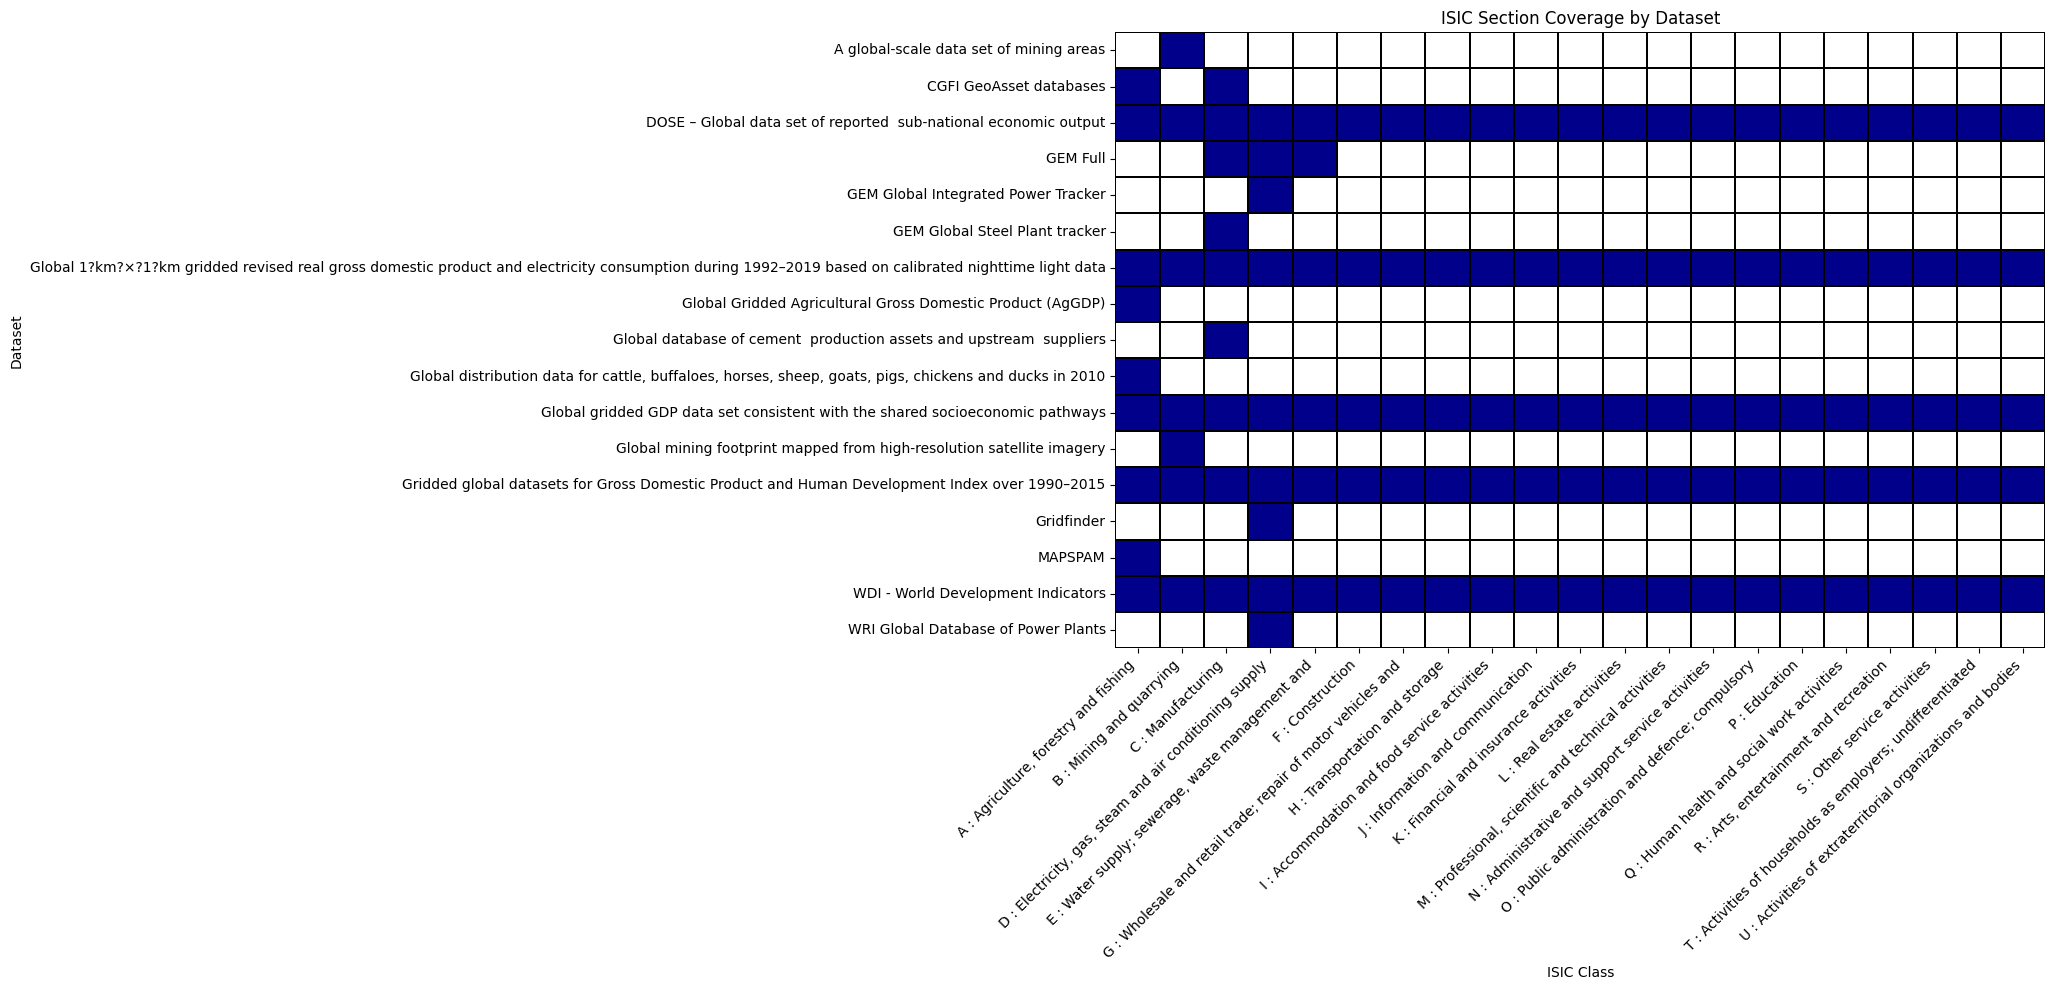

In [6]:
# Define all ISIC letters from A to U
all_isic_letters = list(string.ascii_uppercase[:21])  # 'A' to 'U'

# Function to expand ISIC letter ranges
def expand_isic_letters(isic_value):
    expanded_letters = set()
    for part in str(isic_value).split(","):
        part = part.strip()
        if "-" in part:  # Handle ranges like "A-U"
            start, end = part.split("-")
            if start in all_isic_letters and end in all_isic_letters:
                expanded_letters.update(all_isic_letters[all_isic_letters.index(start): all_isic_letters.index(end) + 1])
        elif part in all_isic_letters:  # Handle single letters
            expanded_letters.add(part)
    return list(expanded_letters)

# Select relevant columns
df_subset = df[['ISIC Letter', 'Dataset']].dropna()

# Expand ISIC letters for each dataset
expanded_rows = []
for _, row in df_subset.iterrows():
    expanded_letters = expand_isic_letters(row["ISIC Letter"])
    for letter in expanded_letters:
        expanded_rows.append((row["Dataset"], letter))

# Create a new DataFrame with expanded values
df_expanded = pd.DataFrame(expanded_rows, columns=['Dataset', 'ISIC Letter'])

# Create binary coverage matrix
coverage_matrix = df_expanded.pivot_table(index='Dataset', columns='ISIC Letter', aggfunc=lambda x: 1, fill_value=0)

# Ensure all ISIC letters are included as columns
coverage_matrix = coverage_matrix.reindex(columns=all_isic_letters, fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(coverage_matrix, cmap=["white", "darkblue"], cbar=False, linecolor="black", linewidths=.2)

plt.xlabel("ISIC Class")
plt.ylabel("Dataset")
plt.title("ISIC Section Coverage by Dataset")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# ax.set_xticks(range(len(df_expanded))) # <--- set the ticks first
ax.set_xticklabels([x + " : " + isic_dict["Section " + x]["description"].split("\n")[0] for x in all_isic_letters])
plt.show()

## Lollipop

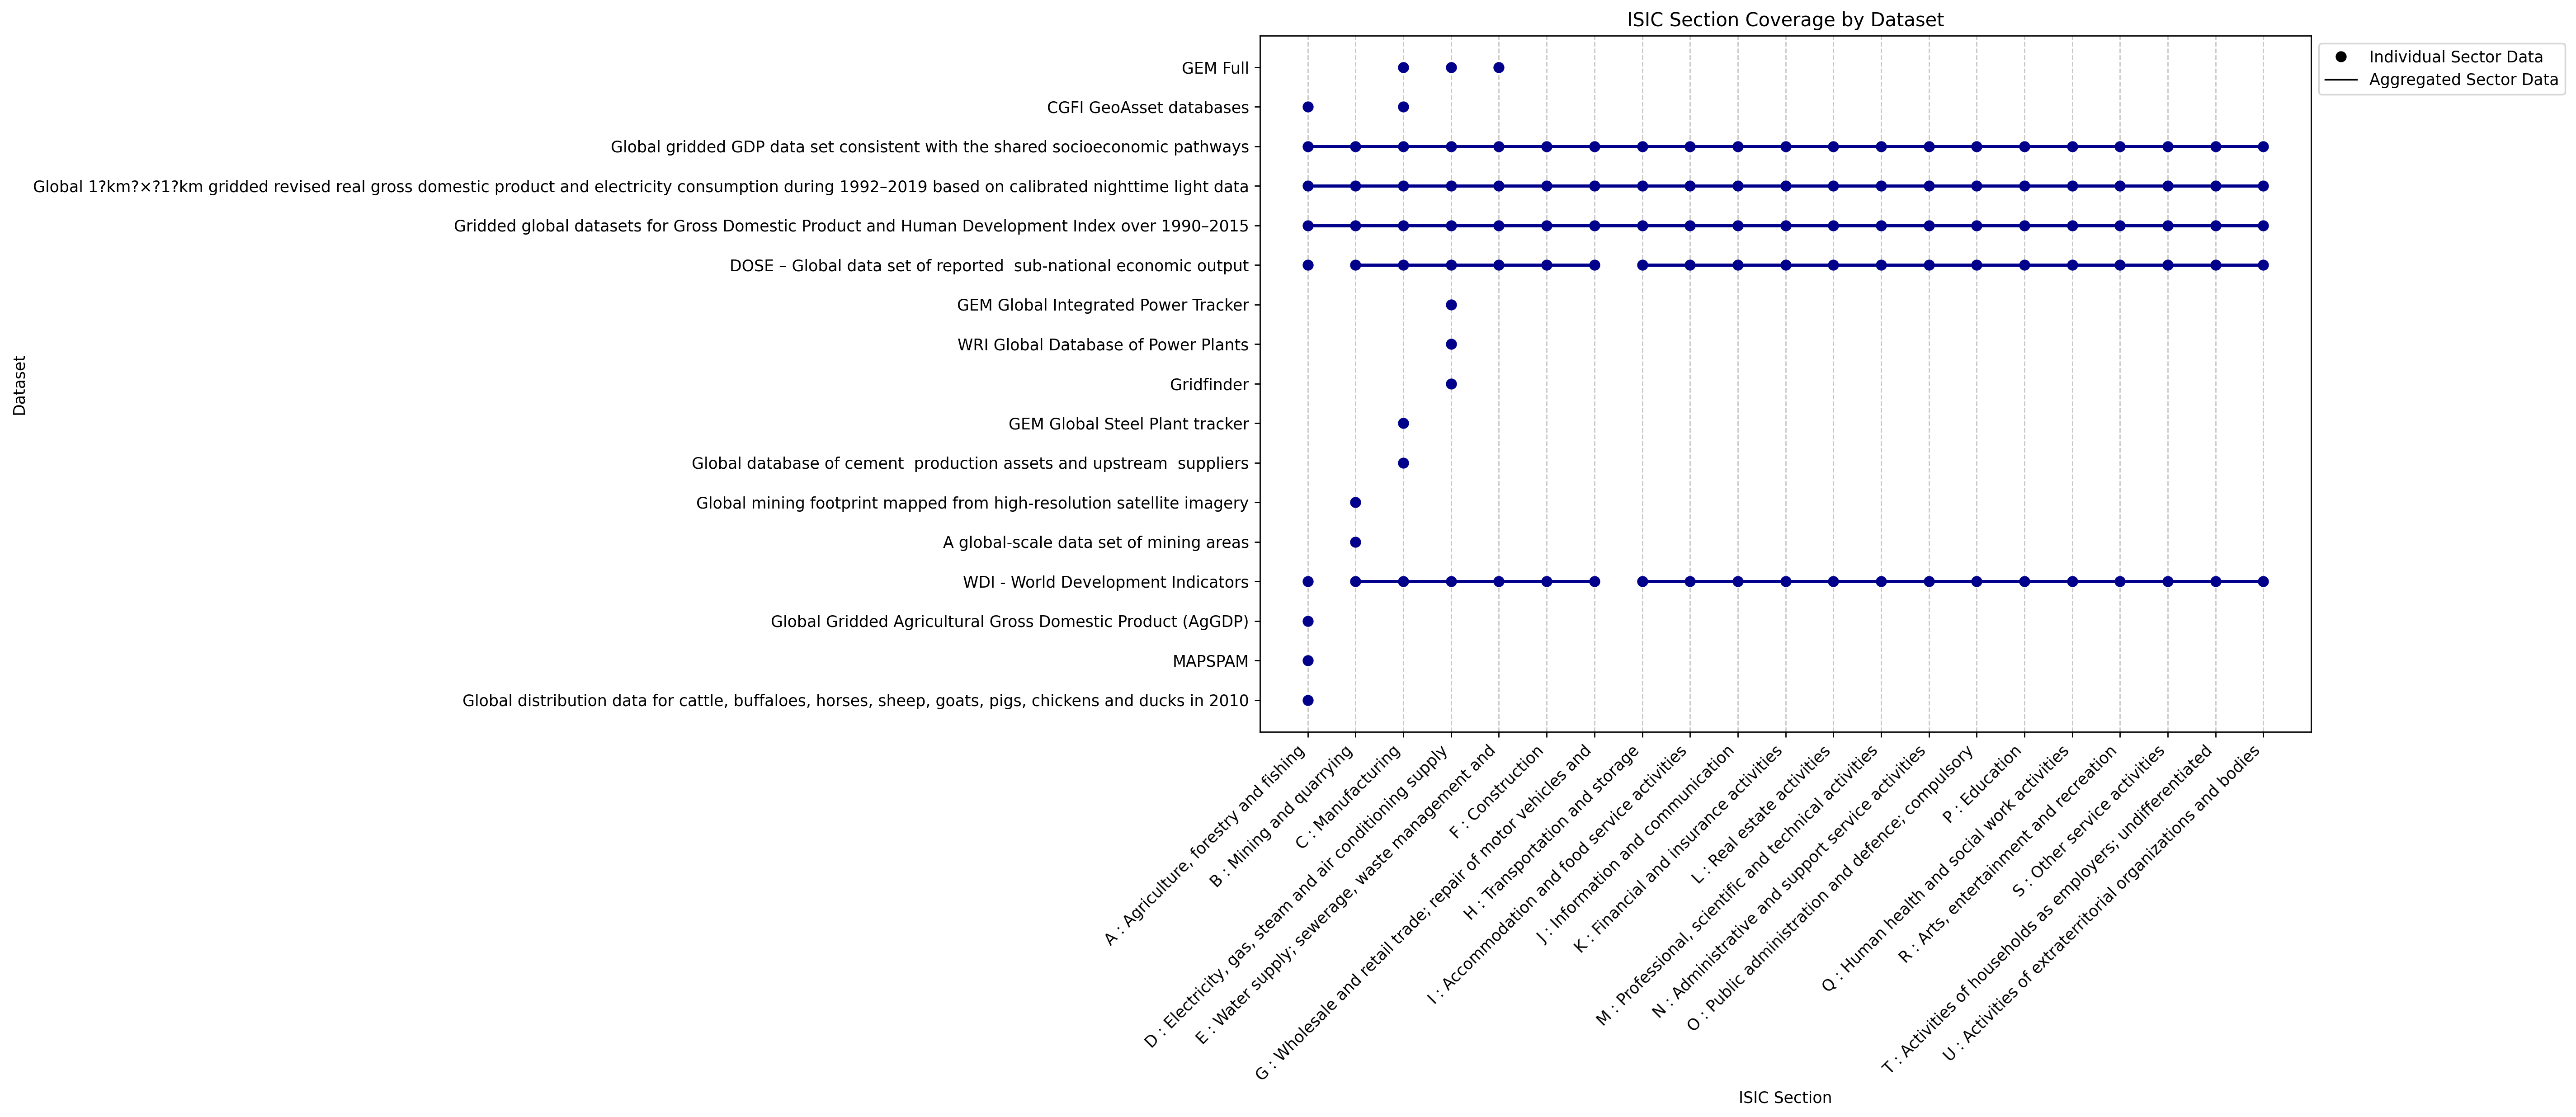

In [7]:
# Function to expand ISIC letter ranges and detect aggregation
def expand_isic_letters(isic_value):
    expanded_letters = []
    aggregated_ranges = []
    
    for part in str(isic_value).split(","):
        part = part.strip()
        if "-" in part:  # Handle ranges like "A-U"
            start, end = part.split("-")
            if start in all_isic_letters and end in all_isic_letters:
                range_letters = all_isic_letters[all_isic_letters.index(start): all_isic_letters.index(end) + 1]
                aggregated_ranges.append((start, end))  # Store as aggregated range
                expanded_letters.extend(range_letters)  # Add to the letter list
        elif part in all_isic_letters:  # Handle single letters
            expanded_letters.append(part)
    
    return list(set(expanded_letters)), aggregated_ranges

# Select relevant columns
df_subset = df[['ISIC Letter', 'Dataset']].dropna()

# Expand ISIC letters and track aggregation
expanded_rows = []
aggregated_edges = []
for _, row in df_subset.iterrows():
    expanded_letters, aggregated_ranges = expand_isic_letters(row["ISIC Letter"])
    for letter in expanded_letters:
        expanded_rows.append((row["Dataset"], letter))
    for start, end in aggregated_ranges:
        aggregated_edges.append((row["Dataset"], start, end))

# Create a new DataFrame with expanded values
df_expanded = pd.DataFrame(expanded_rows, columns=['Dataset', 'ISIC Letter'])

# Plot lollipop chart
plt.figure(figsize=(12,8),dpi=250)

datasets = df_expanded["Dataset"].unique()
for dataset in datasets:
    dataset_rows = df_expanded[df_expanded["Dataset"] == dataset]
    x_values = [all_isic_letters.index(letter) for letter in dataset_rows["ISIC Letter"]]
    y_values = [list(datasets).index(dataset)] * len(x_values)
    plt.scatter(x_values, y_values, color='darkblue', zorder=2,label="Individual Sector Data")
    
    # Plot aggregated ranges as lines
    for _, start, end in aggregated_edges:
        if _ == dataset:
            x_start = all_isic_letters.index(start)
            x_end = all_isic_letters.index(end)
            y = list(datasets).index(dataset)
            plt.plot([x_start, x_end], [y, y], color='darkblue', linewidth=2, zorder=1,label="Aggregated Sector Data")

plt.xticks(range(len(all_isic_letters)), [x + " : " + isic_dict["Section " + x]["description"].split("\n")[0] for x in all_isic_letters],rotation=45, ha='right')
plt.yticks(range(len(datasets)), datasets)
plt.xlabel("ISIC Section")
plt.ylabel("Dataset")
plt.title("ISIC Section Coverage by Dataset")
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Add legend
# Add legend outside the plot
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label="Individual Sector Data"),
    plt.Line2D([0], [0], color='black', lw=1, label="Aggregated Sector Data")
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
# plt.savefig("img/isic_section_coverage.png")
plt.show()

## With more colors for infered sectors

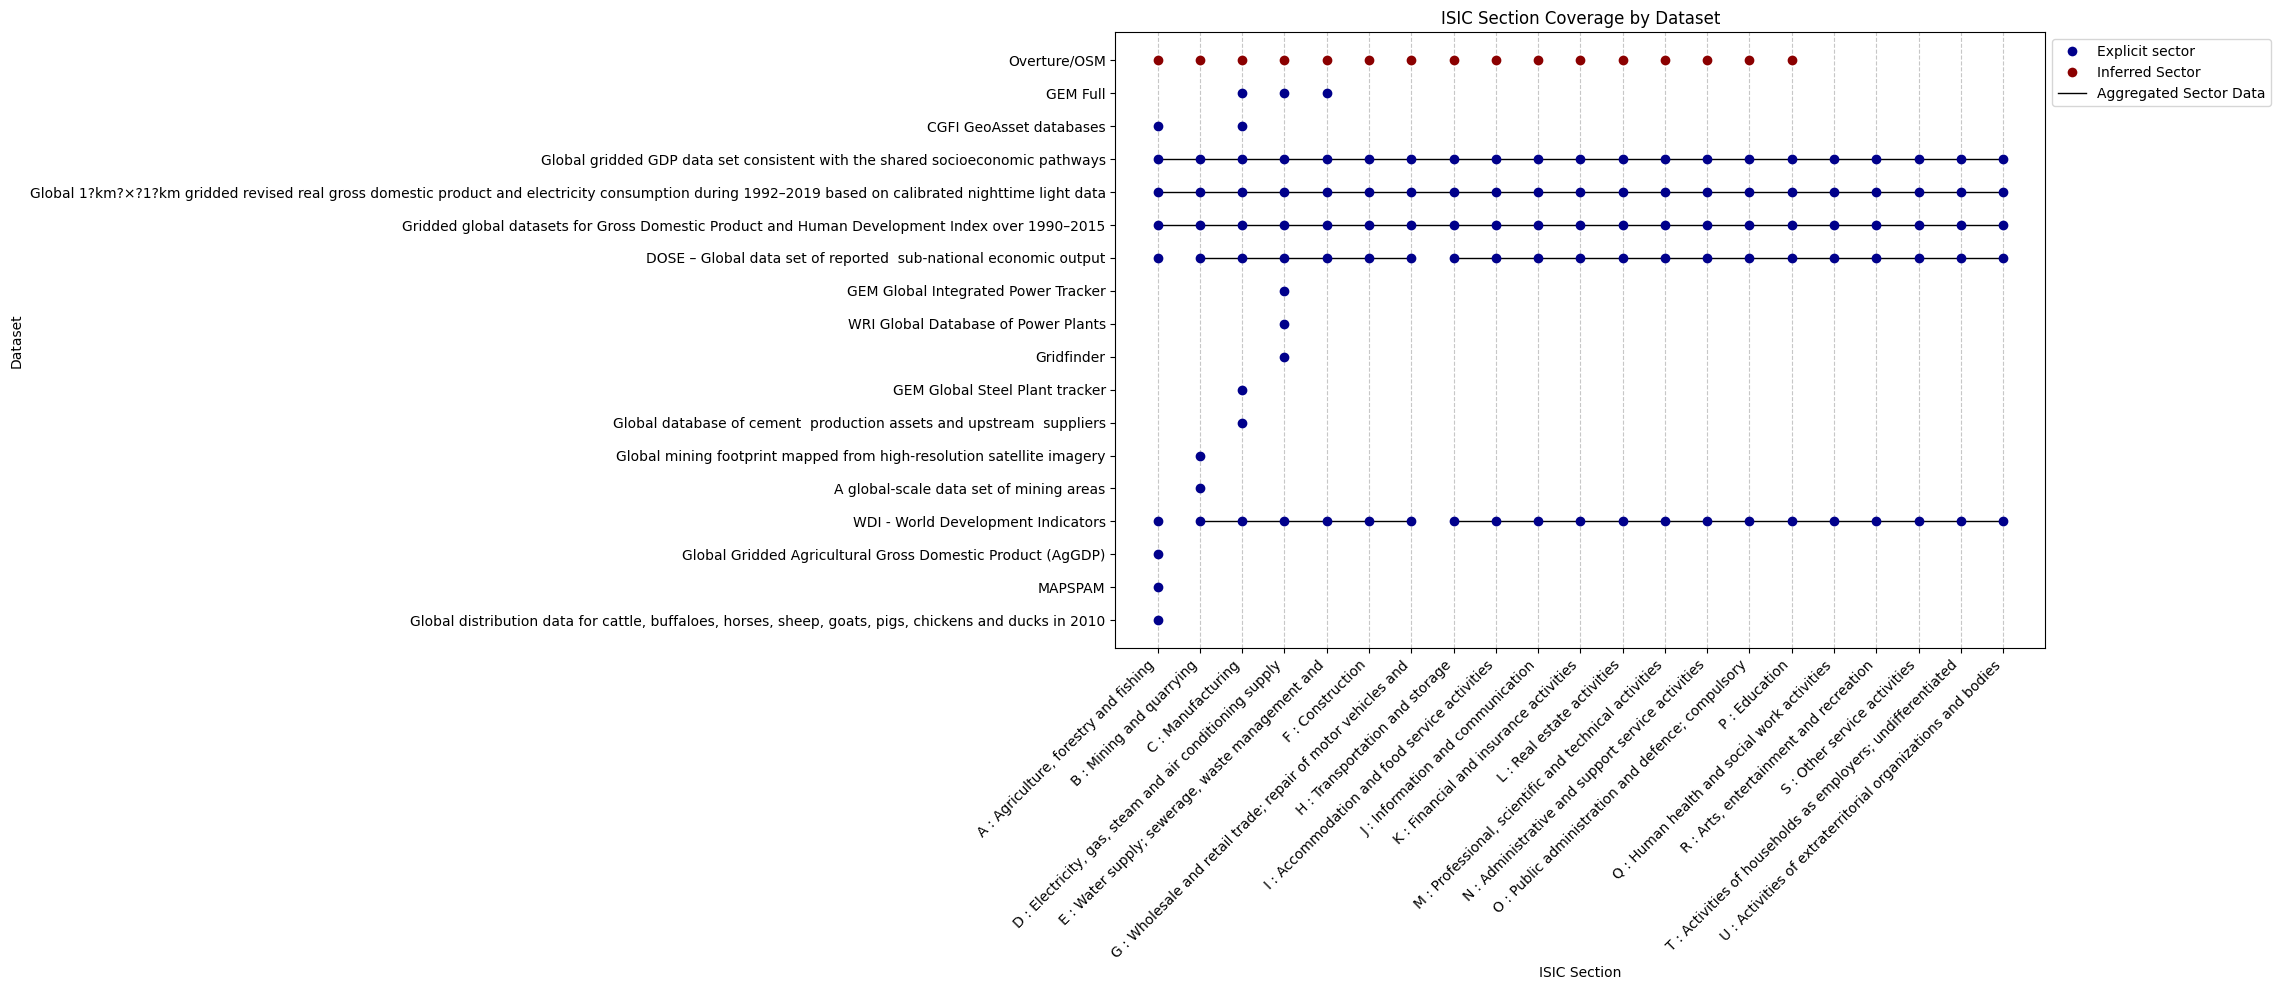

In [10]:
# Function to expand ISIC letter ranges and detect aggregation
def expand_isic_letters(isic_value):
    expanded_letters = []
    aggregated_ranges = []
    
    for part in str(isic_value).split(","):
        part = part.strip()
        if "-," in part:  # Handle separated ranges treated as individual letters, e.g., "A,-C"
            start, end = part.replace("-", "").split(",")
            if start in all_isic_letters and end in all_isic_letters:
                range_letters = all_isic_letters[all_isic_letters.index(start): all_isic_letters.index(end) + 1]
                expanded_letters.extend(range_letters)  # Treat each letter separately
        elif "-" in part and not part.endswith(","):  # Handle aggregated ranges like "A-U"
            start, end = part.split("-")
            if start in all_isic_letters and end in all_isic_letters:
                range_letters = all_isic_letters[all_isic_letters.index(start): all_isic_letters.index(end) + 1]
                aggregated_ranges.append((start, end))  # Store as aggregated range
                expanded_letters.extend(range_letters)
        elif part in all_isic_letters or part in string.ascii_lowercase:  # Handle single letters (both cases)
            expanded_letters.append(part)
    
    return list(set(expanded_letters)), aggregated_ranges

# Expand ISIC letters and track aggregation

expanded_rows = []
aggregated_edges = []
for _, row in df_subset.iterrows():
    expanded_letters, aggregated_ranges = expand_isic_letters(row["ISIC Letter"])
    for letter in expanded_letters:
        expanded_rows.append((row["Dataset"], letter))
    for start, end in aggregated_ranges:
        aggregated_edges.append((row["Dataset"], start, end))

# Create a new DataFrame with expanded values
df_expanded = pd.DataFrame(expanded_rows, columns=['Dataset', 'ISIC Letter'])

# Plot lollipop chart
plt.figure(figsize=(12, 8))

datasets = df_expanded["Dataset"].unique()
for dataset in datasets:
    dataset_rows = df_expanded[df_expanded["Dataset"] == dataset]
    uppercase_rows = dataset_rows[dataset_rows["ISIC Letter"].str.isupper()]
    lowercase_rows = dataset_rows[dataset_rows["ISIC Letter"].str.islower()]
    
    # Plot uppercase letters (dark blue circles)
    x_upper = [all_isic_letters.index(letter) for letter in uppercase_rows["ISIC Letter"]]
    y_upper = [list(datasets).index(dataset)] * len(x_upper)
    plt.scatter(x_upper, y_upper, color='darkblue', zorder=2, label="Individual Uppercase Sector Data" if dataset == datasets[0] else "")
    
    # Plot lowercase letters (darker blue circles)
    x_lower = [all_isic_letters.index(letter.upper()) for letter in lowercase_rows["ISIC Letter"] if letter.upper() in all_isic_letters]
    y_lower = [list(datasets).index(dataset)] * len(x_lower)
    plt.scatter(x_lower, y_lower, color='darkred', zorder=2, label="Individual Lowercase Sector Data" if dataset == datasets[0] else "")
    
    # Plot aggregated ranges as lines
    for _, start, end in aggregated_edges:
        if _ == dataset:
            x_start = all_isic_letters.index(start)
            x_end = all_isic_letters.index(end)
            y = list(datasets).index(dataset)
            plt.plot([x_start, x_end], [y, y], color='black', linewidth=1, zorder=1, label="Aggregated Sector Data" if dataset == datasets[0] else "")

plt.xticks(range(len(all_isic_letters)), [x + " : " + isic_dict["Section " + x]["description"].split("\n")[0] for x in all_isic_letters],rotation=45, ha='right')
plt.yticks(range(len(datasets)), datasets)
plt.xlabel("ISIC Section")
plt.ylabel("Dataset")
plt.title("ISIC Section Coverage by Dataset")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend outside the plot
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', markersize=8, label="Explicit sector"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=8, label="Inferred Sector"),
    plt.Line2D([0], [0], color='black', lw=1, label="Aggregated Sector Data")
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [9]:
expand_isic_letters("A,C-E")

(['C', 'E', 'D', 'A'], [('C', 'E')])